In [9]:
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread
import cv2

from gen.load_data import load_data
from gen.datagen import oversample_generator_from_df, balanced_generator_from_df, random_mask


In [11]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../../data')


In [12]:
train_df.head()

image                   id  \
0  ../../data/Train/CameraRGB/episode_0002_000287...  episode_0002_000287   
1  ../../data/Train/CameraRGB/episode_0008_000112...  episode_0008_000112   
2                 ../../data/Train/CameraRGB/804.png                  804   
3  ../../data/Train/CameraRGB/episode_0008_000286...  episode_0008_000286   
4               ../../data/Train/CameraRGB/M2-25.png                M2-25   

                                               label  
0  ../../data/Train/CameraSeg/episode_0002_000287...  
1  ../../data/Train/CameraSeg/episode_0008_000112...  
2                 ../../data/Train/CameraSeg/804.png  
3  ../../data/Train/CameraSeg/episode_0008_000286...  
4               ../../data/Train/CameraSeg/M2-25.png

In [13]:
valid_df.head()

image                   id  \
0               ../../data/Valid/CameraRGB/00019.png                00019   
1  ../../data/Valid/CameraRGB/episode_0005_000117...  episode_0005_000117   
2               ../../data/Valid/CameraRGB/00413.png                00413   
3               ../../data/Valid/CameraRGB/00035.png                00035   
4               ../../data/Valid/CameraRGB/00264.png                00264   

                                               label  
0               ../../data/Valid/CameraSeg/00019.png  
1  ../../data/Valid/CameraSeg/episode_0005_000117...  
2               ../../data/Valid/CameraSeg/00413.png  
3               ../../data/Valid/CameraSeg/00035.png  
4               ../../data/Valid/CameraSeg/00264.png

In [14]:
test_df.head()

image                   id  \
0  ../../data/Test/CameraRGB/episode_0008_000112.png  episode_0008_000112   
1                ../../data/Test/CameraRGB/00019.png                00019   
2  ../../data/Test/CameraRGB/episode_0012_000130.png  episode_0012_000130   
3  ../../data/Test/CameraRGB/episode_0010_000160.png  episode_0010_000160   
4                ../../data/Test/CameraRGB/00413.png                00413   

                                               label  
0  ../../data/Test/CameraSeg/episode_0008_000112.png  
1                ../../data/Test/CameraSeg/00019.png  
2  ../../data/Test/CameraSeg/episode_0012_000130.png  
3  ../../data/Test/CameraSeg/episode_0010_000160.png  
4                ../../data/Test/CameraSeg/00413.png

In [26]:
gen = oversample_generator_from_df(train_df, 10, (416, 800))

In [27]:
X, Y = next(gen)


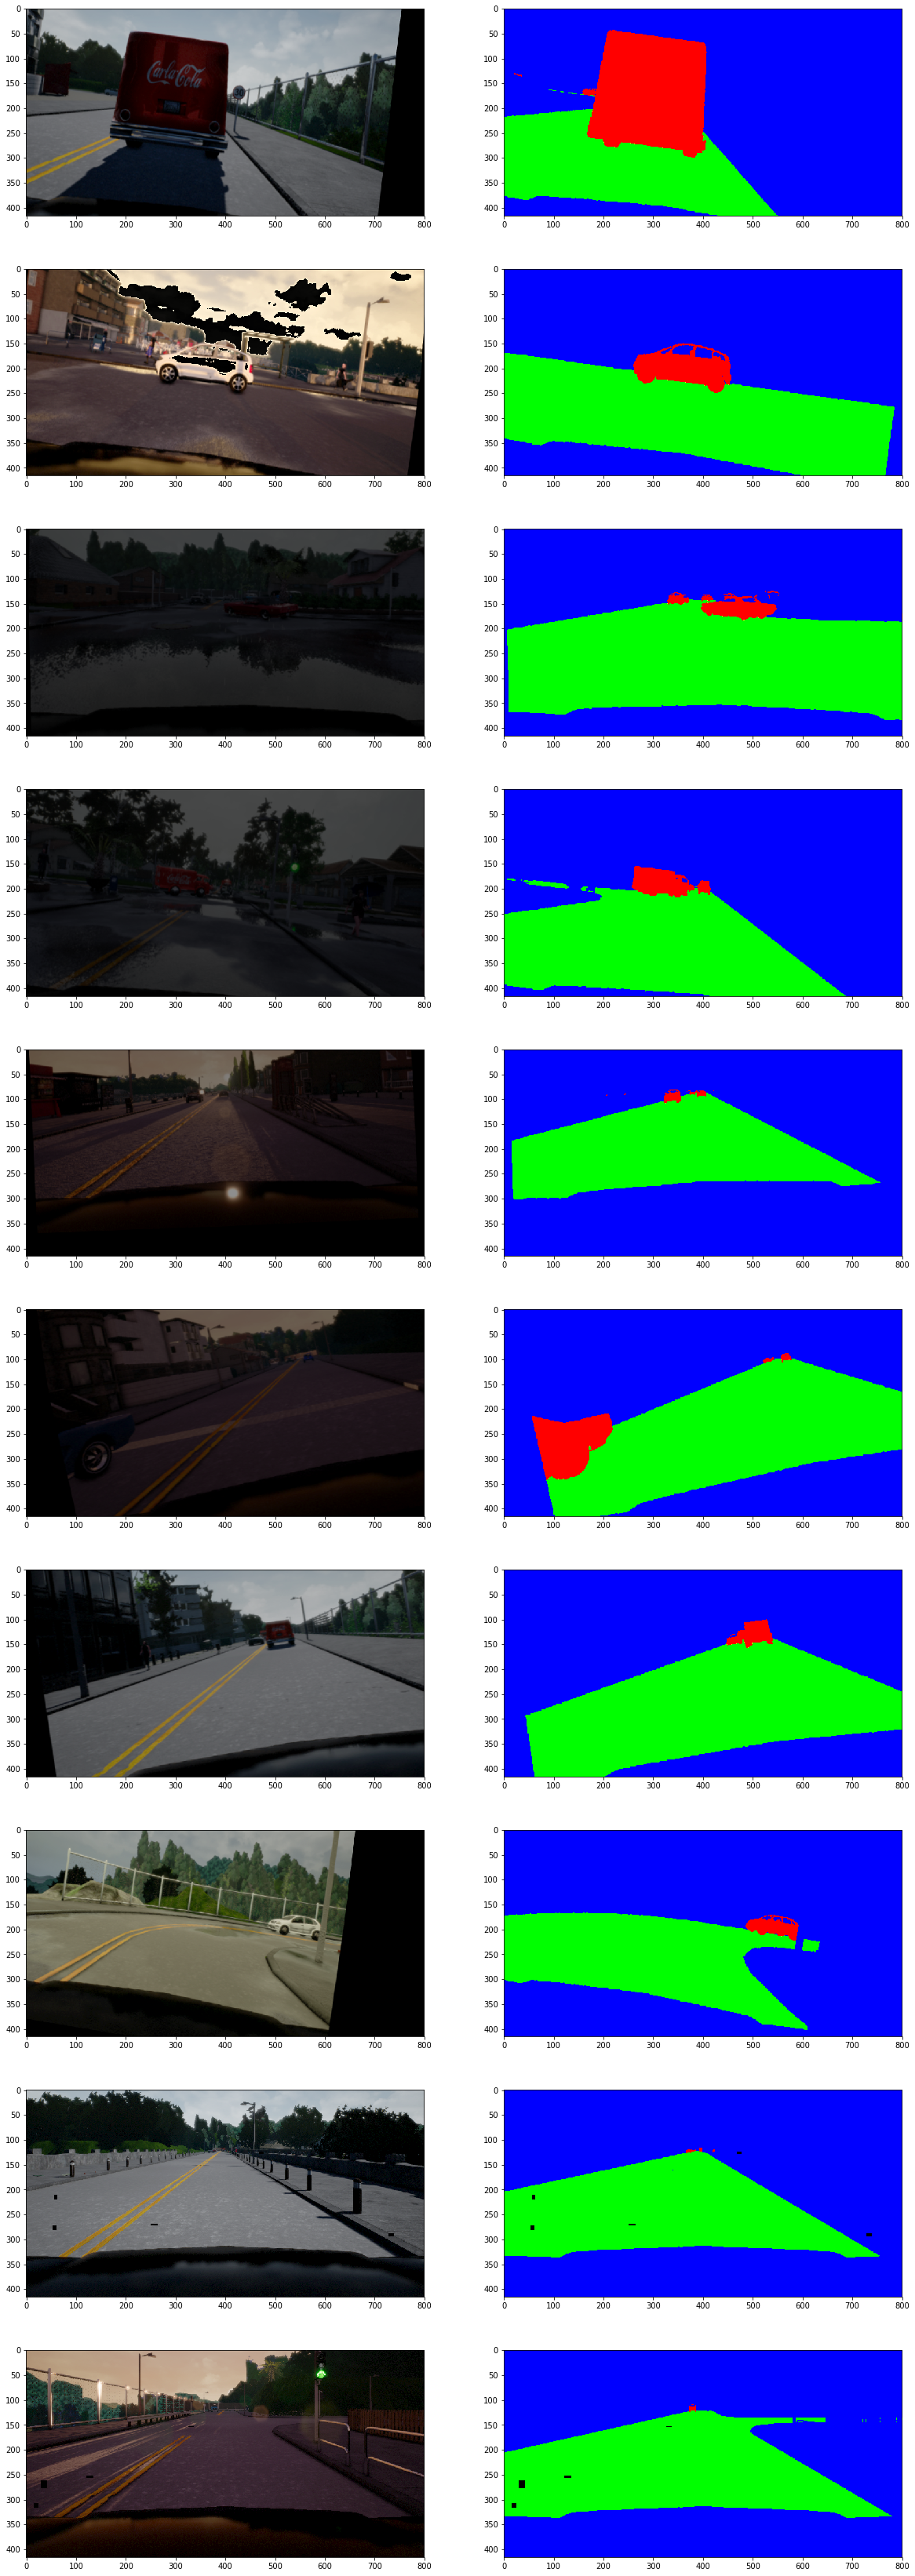

In [28]:
sample_rows = 10

fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
for (ax1, ax2), x, y in zip(m_axs, X, Y):
    ax1.imshow(x.astype(np.uint8))
    ax2.imshow(y*255)

In [29]:
gen_2 = balanced_generator_from_df(valid_df, 12, (416, 800))

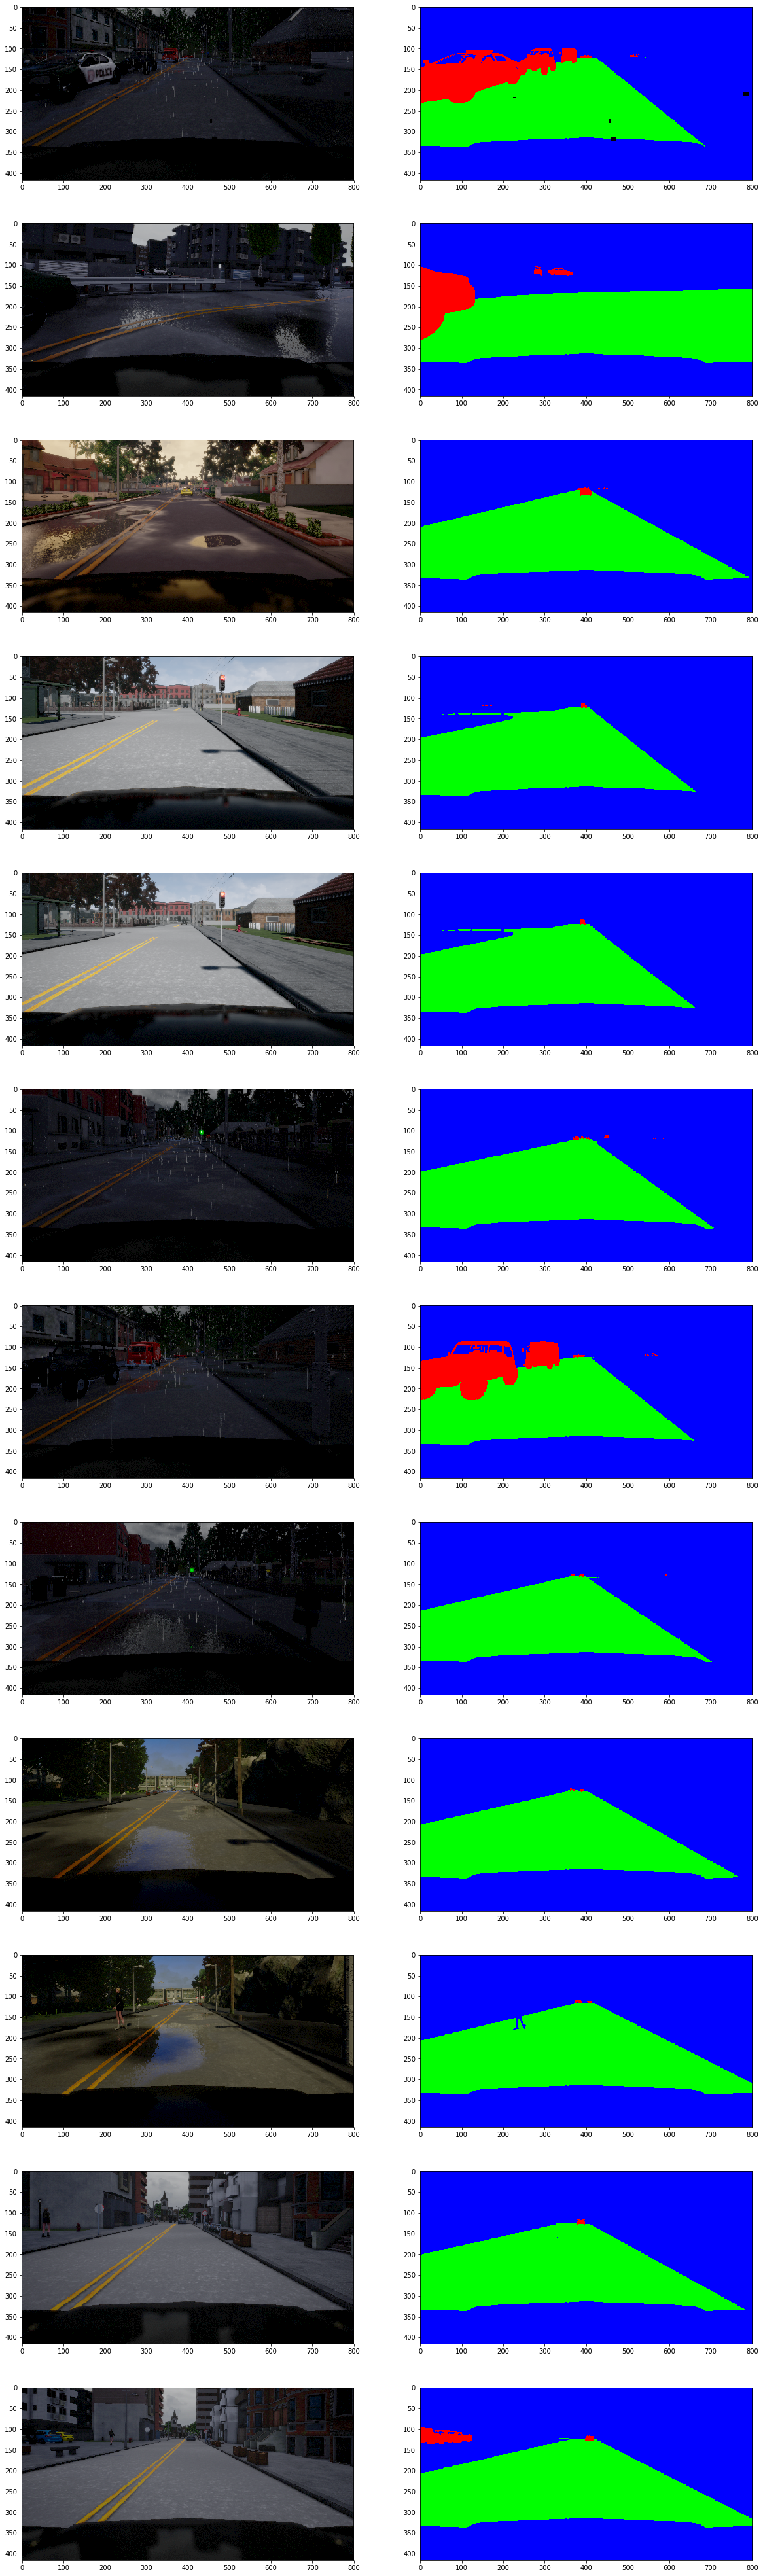

In [30]:
X, Y = next(gen_2)

X[0], Y[0] = random_mask(X[0], Y[0])

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
for (ax1, ax2), x, y in zip(m_axs, X, Y):
    ax1.imshow(x)
    ax2.imshow(y*255)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(141)
plt.imshow(imread(train_df.iloc[major_indices[0]].image))
plt.subplot(142)
plt.imshow(imread(train_df.iloc[major_indices[1]].image))
plt.subplot(143)
plt.imshow(imread(train_df.iloc[major_indices[2]].image))
plt.subplot(144)
plt.imshow(imread(train_df.iloc[major_indices[3]].image))

In [ ]:
def gen_oversample_minority_class(df, batch_size, target_size, weights):
  nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)

  count =1
  epoch = 0


  while 1:
    epoch += 1
    i, j = 0, batch_size
    # Mini-batches within epoch.
    mini_batches_completed = 0
    for _ in range(nbatches):
      # seed = np.random.choice(range(1000))
      sub = df.sample(n=batch_size, replace=False, weights=weights)

      X = np.array([cv2.resize(preprocess_input(img_to_array(imread(f))), (target_size[1], target_size[0])) for f in sub.image])
      Y = np.array([cv2.resize(preprocess_label(img_to_array(imread(f))), (target_size[1], target_size[0])) for f in sub.label])

      yield X, Y
      i = j
      j += batch_size
      count += 1

In [ ]:
def plot_next_batch():
    X, Y = next(gen)

    sample_rows = 12
    fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
    for (ax1, ax2), rgb_img, lab_img in zip(m_axs, X, Y):
        img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
        lab_img = np.clip(lab_img*255, 0, 255).astype(np.uint8)
        ax1.imshow(img)
        ax1.set_title('Color')
        ax2.imshow(lab_img[:, :, 0:3])
        ax2.set_title('Labels')
plot_next_batch()

In [ ]:
plot_next_batch()

In [ ]:
plot_next_batch()

In [ ]:
plot_next_batch()

In [ ]:

from gen.generators import preprocess_label

bg, road, cars = 0, 0, 0
for i, row in train_df.sample(2500).iterrows():
    l = preprocess_label(imread(row['label']))
    
    cars += l[:, :, 0].nonzero()[1].shape[0]
    road += l[:, :, 1].nonzero()[1].shape[0]
    bg   += l[:, :, 2].nonzero()[1].shape[0]

print (bg, road, cars)

t = bg + road + cars
car_p = cars/t
road_p = road/t
bg_p = bg/t

In [ ]:
print ("Car {}%, Road {}%, BG {}%".format(car_p, road_p, bg_p))

In [ ]:
t = cars+bg+road
p_car = t/cars
p_road = t/road
p_bg = t/bg

print(p_car, p_road, p_bg)

In [ ]:
(rgb_batch, lab_batch) = next(train_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(cv2.cvtColor(r_rgb_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [ ]:
def gen_test():
    print ("Generating")
    while 1:
        i = 0
        for _ in range(10):
            x = i
            yield x
            i += 1


In [ ]:
g = gen_test()

In [ ]:
next(g)